# Data

# Load libraries

In [117]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [118]:
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

# Load data

In [119]:
data_url = 'https://raw.githubusercontent.com/himalayahall/DATA607/main/Project4/SMSSpamCollection.txt'
df = pd.read_csv(data_url, names=["category", "sms"], skip_blank_lines=True, skiprows=1, delimiter='\t')

View data.

In [120]:
df.head()

,category,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Describe data.

In [121]:
df.describe()

,category,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Neural networks work with numeric data only. In our data set we have 2 categorical variables - **category** and **sms**.  

First, mutate **category** from categorical to numeric data type. And following standard naming convention, change column name to **target**.  

The second column, **sms**, is not mutated (yet). Data from this column will be automatically changed using the Google **word embedding** model.

In [122]:
df['target'] = pd.Categorical(df['category'])
df['target'] = df.target.cat.codes
df = df.drop(['category'], axis=1)
df.head()

,sms,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Define a function to create training, testing, and validation data splits. Basically, the idea if to use a subset of the data for training the classifier model,  another subset for validating the model during training, and the final subset to test the model. This is standard practice for building robust classifiers.

In [52]:
def split_train_test_val(df : pd.DataFrame, train_prop : float = 0.75, val_prop : float = 0.9):
      """
          Parameters
          ----------
          df : pd.DataFrame
              Data frame
          train_size : float
              If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. 
              If None, it will be set to 0.75. The test set will be set to it's compliment.
          val_size : float
              If float, should be between 0.0 and 1.0 and represent the proportion of the test dataset to include in the validation split. If int, represents the absolute number of validation samples. 
              If None, it will be set to 0.9.
       """
      train, test = train_test_split(df, train_size=train_prop)
      test, val = train_test_split(test, train_size = val_prop)
      print(len(train), 'train examples')
      print(len(test), 'test examples')
      print(len(val), 'validation examples')
      return train, test, val

Create train, test, validate splits.  

Extract examples and labels from each of the 3 splits.

In [53]:
train, test, val = split_train_test_val(df)

X_train = np.array(train['sms'])
y_train = np.array(train['target'])

X_test = np.array(test['sms'])
y_test = np.array(test['target'])

X_val = np.array(val['sms'])
y_val = np.array(val['target'])


4179 train examples
1253 test examples
140 validation examples


Print proportion of spam/ham and length of splits. Validate train/test splits have similar proportion of ham (0) and spam (1) as the original data.

In [54]:
print("Len: " + str(df.sms.count()))
print(str(df.target.value_counts() / len(df)))
print('-----------------------')

splits = {"train": train, "test": test, "val": val}
for s_name in splits:
  s = splits[s_name]
  print(s_name + ": " + str(s['sms'].count()))
  print('-----------------------')

Len: 5572
0    0.865937
1    0.134063
Name: target, dtype: float64
-----------------------
train: 4179
-----------------------
test: 1253
-----------------------
val: 140
-----------------------


In [55]:
def df_to_dataset(df, shuffle=False, batch_size=32):
  '''
    Convert pd.DataFrame to tf.data.Dataset.
    Parameters:
      df - Dataframe.
      shuffle - True to shuffle df before conversion. Otherwise False.
      batch_size - Batch size of dataset.
  '''
  pd.dat
  dataframe = df.copy()
  labels = df.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  return ds

Use token based text embedding model trained on English Google News 7B corpus. By using this model we avoid the need to create embeddings for the **sms** string variable. 

Note, the embedding layer is *trainable*. Although training is slower, the embedding model learns during training and model performance improves significantly.

In [56]:
embedding = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", input_shape=[], dtype=tf.string, trainable=True)

Create *Sequential* Tensorflow NN model, Google text embedding is added to model as the input layer.

In [57]:
model = tf.keras.Sequential()
model.add(embedding)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_18 (Dense)            (None, 128)               6528      
                                                                 
 dense_19 (Dense)            (None, 16)                2064      
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 48,199,209
Trainable params: 48,199,209
Non-trainable params: 0
_________________________________________________________________


Compile model.

In [58]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])

Fit model with training data. Note, validation split is used during model training.

In [59]:
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    validation_data=(X_val, y_val)
                    )

Epoch 1/5
131/131 [==============================] - 75s 565ms/step - loss: 0.2713 - accuracy: 0.9040 - val_loss: 0.1234 - val_accuracy: 0.9571
Epoch 2/5
131/131 [==============================] - 72s 548ms/step - loss: 0.0575 - accuracy: 0.9849 - val_loss: 0.1087 - val_accuracy: 0.9714
Epoch 3/5
131/131 [==============================] - 71s 541ms/step - loss: 0.0220 - accuracy: 0.9943 - val_loss: 0.1024 - val_accuracy: 0.9714
Epoch 4/5
131/131 [==============================] - 70s 538ms/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.1052 - val_accuracy: 0.9643
Epoch 5/5
131/131 [==============================] - 79s 601ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.1123 - val_accuracy: 0.9643


In [68]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix

def evaluateModel(model):

  preds = model.predict(X_test, verbose=1)
  preds_flat = [x[0] for x in preds]
  preds_flat_labels = [1 if x > 0.5 else 0 for x in preds]

  target_names = ['0', '1']
  cm = confusion_matrix(y_test, preds_flat_labels)

  cm_display = ConfusionMatrixDisplay(cm).plot()
  
  loss, accuracy = model.evaluate(X_test, y_test)
  print("Accuracy", accuracy)

  fpr, tpr, _ = roc_curve(y_test, preds)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
  

Evaluate model against the test split.

40/40 [==============================] - 3s 71ms/step - loss: 0.1010 - accuracy: 0.9785
Accuracy 0.9784517288208008


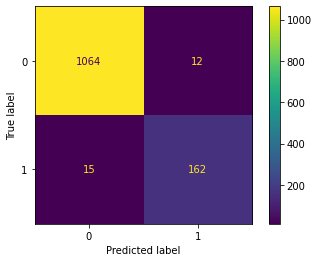

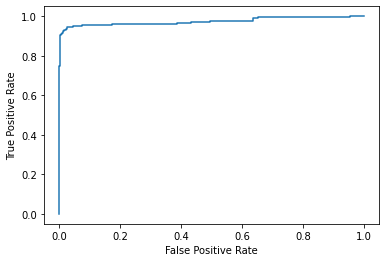

In [69]:
evaluateModel(model)

Finaly, let's create a Wordcloud from our data. The Wordcloud will disp[lay the 100 most frequently appearing words in the corpus (ignoring stopwords). 

In [138]:
sms_words = ""
for val in df.sms:
     
    # Lowercase each word
    tokens = [tok.lower() for tok in val.split()]
     
    sms_words += " ".join(tokens)


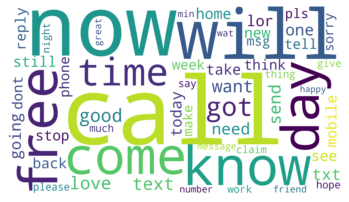

In [143]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',  width = 1920, height = 1080,
                      min_word_length=3,
                collocations = False,
                stopwords = stopwords,
                max_words = 100,
                min_font_size = 50).generate(sms_words)
 
 # plot the WordCloud image                      
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


453434